## hcds-a1-data-curation

### Purpose
This notebook details the steps needed to construct and analyze a dataset of monthly traffic on English Wikipedia from January 2008 to September 2017.  It is divided into three sections: 

1. Data acquisition - collecting data from two different APIs 
2. Data processing - preparing the data in (1) for analysis 
3. Analysis - visualizing the dataset created in (2) as a time series graph 

### 1. Data acquisition

Data were collected from two API endpoints: 
1. __[Pagecount API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts)__. This API provides counts for human and automated traffic combined (at various levels of granularity) from January 2008 to July 2016. 
2. __[Pageviews API](https://https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews)__. This API provides counts of traffic for human and automated (e.g. web crawlers, spiders) separately (at various levels of granularity) from July 2015 to the present. 

When calling the Pageviews API, automated traffic was excluded by specifying /user/ in the endpoint.  For example: 
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2017100100

#### Setup - loading packages and setting the working directory.   This assumes that the packages 'httr, 'jsonlite', 'data.table', 'plyr', 'lubridate', which are available from __[CRAN](https://cran.r-project.org/)__, have been installed.  

In [ ]:
## Load packages 
library(httr)
library(jsonlite)
library(data.table)
library(plyr)
library(lubridate)
library(tidyr) 
library(ggplot2)


## Set wd 
wd <- "/Users/MB/Desktop/DATA_512/Week 3/Assignment/"       # specify working directory here 
setwd(wd)

####  a) Extract data from Pagecounts API using GET command from httr package and convert to JSON 

In [ ]:
## English, Desktop Site, Monthly, 1 Jan 2008 to 31 July 2016 
pagecounts_desktop_url <- "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2016080100"
pagecounts_desktop <- GET(pagecounts_desktop_url)
pagecounts_desktop.json <- toJSON(content(pagecounts_desktop))


## English, Mobile Site, Monthly, 1 Jan 2008 to 31 July 2016 
pagecounts_mobile_url <- "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/mobile-site/monthly/2008010100/2016080100"
pagecounts_mobile <- GET(pagecounts_mobile_url)
pagecounts_mobile.json <- toJSON(content(pagecounts_mobile))

#### b) Extract data from Pageviews API using GET command from httr package and convert to JSON - consider only user traffic  

In [ ]:
## English, Desktop Site, User traffic, Monthly, 1 Jul 2015 to 30 September 2017 
pageviews_desktop_url <- "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2017100100"
pageviews_desktop <- GET(pageviews_desktop_url)
pageviews_desktop.json <- toJSON(content(pageviews_desktop))

## English, Mobile Web, User Traffic, Monthly, 1 Jul 2015 to 30 September 2017 
pageviews_mobileweb_url <- "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-web/user/monthly/2015070100/2017100100"
pageviews_mobileweb <- GET(pageviews_mobileweb_url)
pageviews_mobileweb.json <- toJSON(content(pageviews_mobileweb))


## English, Mobile App, User Traffic, Monthly, 1 Jul 2015 to 30 September 2017 
pageviews_mobileapp_url <- "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-app/user/monthly/2015070100/2017100100"
pageviews_mobileapp <- GET(pageviews_mobileapp_url)
pageviews_mobileapp.json <- toJSON(content(pageviews_mobileapp))

#### c) Export the JSON objects in b) and c) to the working directory 

In [ ]:
write(pagecounts_desktop.json, "pagecounts_desktop-site_200801-201607.json")
write(pagecounts_mobile.json, "pagecounts_mobile-site_200801-201607.json")
write(pageviews_desktop.json, "pageviews_desktop_201507-201709.json")
write(pageviews_mobileweb.json, "pageviews_mobile-web_201507-201709.json")
write(pageviews_mobileapp.json, "pageviews_mobile-app_201507-201709.json")

### 2. Data processing 

There were five JSON files created in (1): 

- Desktop views during January 2008 to July 2016 from the Pagecounts API
- Mobile views during January 2008 to July 2016 from the Pagecounts API 
- Desktop views during July 2015 to September 2017 from the Pageviews API 
- Mobile App views during July 2015 to September 2017 from the Pageviews API 
- Mobile Web views during July 2015 to September 2017 from the Pageviews API 

These were read into R and converted into data tables. 

#### a) Read in JSON files created in (1) 

In [ ]:
pagecounts_desktop.json <- jsonlite::fromJSON("pagecounts_desktop-site_200801-201607.json")
pagecounts_mobile.json <- jsonlite::fromJSON("pagecounts_mobile-site_200801-201607.json")
pageviews_desktop.json <- jsonlite::fromJSON("pageviews_desktop_201507-201709.json")
pageviews_mobileweb.json <- jsonlite::fromJSON("pageviews_mobile-web_201507-201709.json")
pageviews_mobileapp.json <- jsonlite::fromJSON("pageviews_mobile-app_201507-201709.json")

#### b) Convert JSON files to data.tables 

In [ ]:
pagecounts_desktop <- data.table(pagecounts_desktop.json$items) 
pagecounts_mobile <- data.table(pagecounts_mobile.json$items) 
pageviews_desktop <- data.table(pageviews_desktop.json$items) 
pageviews_mobileweb <- data.table(pageviews_mobileweb.json$items) 
pageviews_mobileapp <- data.table(pageviews_mobileapp.json$items) 

There were some redundant columns in b): project, access, access-site, agent, granularity which were dropped. 

#### c) Drop redundant columns 

In [ ]:
drop_columns <- c("project", "access", "access-site", "agent", "granularity")
pagecounts_desktop[, (drop_columns) := NULL] 
pagecounts_mobile [, (drop_columns) := NULL]
pageviews_desktop[, (drop_columns) := NULL]
pageviews_mobileweb[, (drop_columns) := NULL]
pageviews_mobileapp[, (drop_columns) := NULL]

In pagecounts_desktop and pagecounts_mobile, the two remaining columns were: 
1. timestamp 
2. count 

In pageviews_desktop, pageviews_mobileweb and pageviews_mobileapp, the two remaining columns were: 
1. timestamp 
2. views 

Prior to merging the five data.tables, the views and counts columns were given unique names and a date field was added using the ymd command in the lubridate package. 

#### d) Rename views and counts columns; add date field 

In [ ]:
## Rename views and counts columns 
names(pagecounts_desktop)[2] <- "pagecount_desktop_views" 
names(pagecounts_mobile)[2] <- "pagecount_mobile_views" 
names(pageviews_desktop)[2] <- "pageview_desktop_views"
names(pageviews_mobileweb)[2] <- "pageview_mobileweb_views"
names(pageviews_mobileapp)[2] <- "pageview_mobileapp_views"

## Add date field 
pagecounts_desktop$date <- (ymd(substr(pagecounts_desktop$timestamp, 1, 8)))
pagecounts_mobile$date <- (ymd(substr(pagecounts_mobile$timestamp, 1, 8)))
pageviews_desktop$date <- (ymd(substr(pageviews_desktop$timestamp, 1, 8)))
pageviews_mobileweb$date<- (ymd(substr(pageviews_mobileweb$timestamp, 1, 8)))
pageviews_mobileapp$date<- (ymd(substr(pageviews_mobileapp$timestamp, 1, 8)))

To create a single unified dataset, the five data.tables in d) were merged (full join) on the date column. 

#### e) Merge data.tables in d)  on date 

In [ ]:
merge_set <- list(pagecounts_desktop, pagecounts_mobile, pageviews_desktop, pageviews_mobileweb, pageviews_mobileapp)
pageviews_all <- join_all(merge_set, by="date", type="full")
setDT(pageviews_all)

Since the three pageviews tables only had data going back to July 2015, there were missing data in the merged data.table (represented as NULL) which were replaced with zeros. 

#### f) Replace NULLs in e) with zeros 

In [ ]:
zero_col.fun <- function(x) {
    ifelse(is.null(x), 0, x) 
}

pageviews_all$pagecount_desktop_views <- lapply(pageviews_all$pagecount_desktop_views, zero_col.fun)
pageviews_all$pagecount_mobile_views <- lapply(pageviews_all$pagecount_mobile_views, zero_col.fun)
pageviews_all$pageview_desktop_views <- lapply(pageviews_all$pageview_desktop_views, zero_col.fun)
pageviews_all$pageview_mobileweb_views <- lapply(pageviews_all$pageview_mobileweb_views, zero_col.fun)
pageviews_all$pageview_mobileapp_views <- lapply(pageviews_all$pageview_mobileapp_views, zero_col.fun)

To prepare the final dataset, year and month columns were added to f) and since the components of f) were stored as lists rather than vectors, these were converted to vectors using the unlist function. 

#### g) Add year, months columns to f); unlist listed components

In [ ]:
## Add year, month columns to pageviews_all  
pageviews_all$year <- year(pageviews_all$date)
pageviews_all$month <- month(pageviews_all$date)


## Create new dataframe and unlist listed components 
pageviews_2 <- data.frame(
                  year = pageviews_all$year, 
                  month = pageviews_all$month, 
                  pagecount_desktop_views = unlist(pageviews_all$pagecount_desktop_views), 
                  pagecount_mobile_views = unlist(pageviews_all$pagecount_mobile_views),
                  pageview_desktop_views = unlist(pageviews_all$pageview_desktop_views),
                  pageview_mobileweb_views = unlist(pageviews_all$pageview_mobileweb_views), 
                  pageview_mobileapp_views = unlist(pageviews_all$pageview_mobileapp_views)
                )

In [39]:
head(pageviews_2)

year,month,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobileweb_views,pageview_mobileapp_views
2008,1,4930902570,0,0,0,0
2008,2,4818393763,0,0,0,0
2008,3,4955405809,0,0,0,0
2008,4,5159162183,0,0,0,0
2008,5,5584691092,0,0,0,0
2008,6,5712104279,0,0,0,0


Finally, a new data.frame was created with additional columns: 
- pagecount_all_views = pagecount_desktop_views + pagecount_mobile_views 
- pageview_all_views = pageview_desktop_views + pageview_mobile_web_views + pageview_mobileapp_views 
- pageview_mobile_views = pageview_mobileweb_views + pageview_mobileapp_views 

#### h) Create final dataset 

In [ ]:
pageviews_final <- data.frame(
                    year = pageviews_2$year, 
                    month = pageviews_2$month, 
                    pagecount_all_views = pageviews_2$pagecount_desktop_views + pageviews_2$pagecount_mobile_views, 
                    pagecount_desktop_views = pageviews_2$pagecount_desktop_views, 
                    pagecount_mobile_views = pageviews_2$pagecount_mobile_views, 
                    pageview_all_views = pageviews_2$pageview_desktop_views + pageviews_2$pageview_mobileweb_views + pageviews_2$pageview_mobileapp_views, 
                    pageview_desktop_views = pageviews_2$pageview_desktop_views, 
                    pageview_mobile_views = pageviews_2$pageview_mobileweb_views + pageviews_2$pageview_mobileapp_views
                )

In [40]:
head(pageviews_final)

year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
2008,1,4930902570,4930902570,0,0,0,0
2008,2,4818393763,4818393763,0,0,0,0
2008,3,4955405809,4955405809,0,0,0,0
2008,4,5159162183,5159162183,0,0,0,0
2008,5,5584691092,5584691092,0,0,0,0
2008,6,5712104279,5712104279,0,0,0,0


#### f) Export to CSV

In [ ]:
write.csv(pageviews_final, file="en-wikipedia_traffic_200801_201709.csv", row.names=FALSE)

### 3. Analysis 

In this step, a time series graph was created which showed the trends of: 
- Total views, desktop views and mobile views using the Pagecount API (human and automated traffic) during January 2008 to July 2016 
- Total views, desktop views and mobile views using the Pageviews API (human traffic only) during July 2015 to September 2017

#### a) Read en-wikipedia_traffic_200801_201709.csv into data frame

In [41]:
traffic <- read.csv(file="en-wikipedia_traffic_200801_201709.csv", header=TRUE, sep=",")

Since time series graphs require a date field, a new column, date, was created from the year and month columns. 

#### b) Add date column to traffic 

In [43]:
traffic$date <- parse_date_time(paste(traffic$year, traffic$month, "01", sep="-"), c("%y-%m-%d"))
head(traffic)

year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,date
2008,1,4930902570,4930902570,0,0,0,0,2008-01-01
2008,2,4818393763,4818393763,0,0,0,0,2008-02-01
2008,3,4955405809,4955405809,0,0,0,0,2008-03-01
2008,4,5159162183,5159162183,0,0,0,0,2008-04-01
2008,5,5584691092,5584691092,0,0,0,0,2008-05-01
2008,6,5712104279,5712104279,0,0,0,0,2008-06-01


Since ggplot works best when the data is tidy, the data.frame in b) was reshaped such that both views and the platform (pagecount_desktop, pagecount_mobile etc) were columns.   Furthermore, zeros were replaced by NAs to avoid formatting issues in the time series chart. 

#### c) Reshape data and replace zero with N/A

In [44]:
traffic_tidy <- gather(traffic, key=metric, value=views, -date, -month, -year)
traffic_tidy[traffic_tidy==0] <- NA 

Finally, a time series plot was created using ggplot. 

#### d) Create time series plot using ggplot

Warning message:
“Removed 393 rows containing missing values (geom_path).”

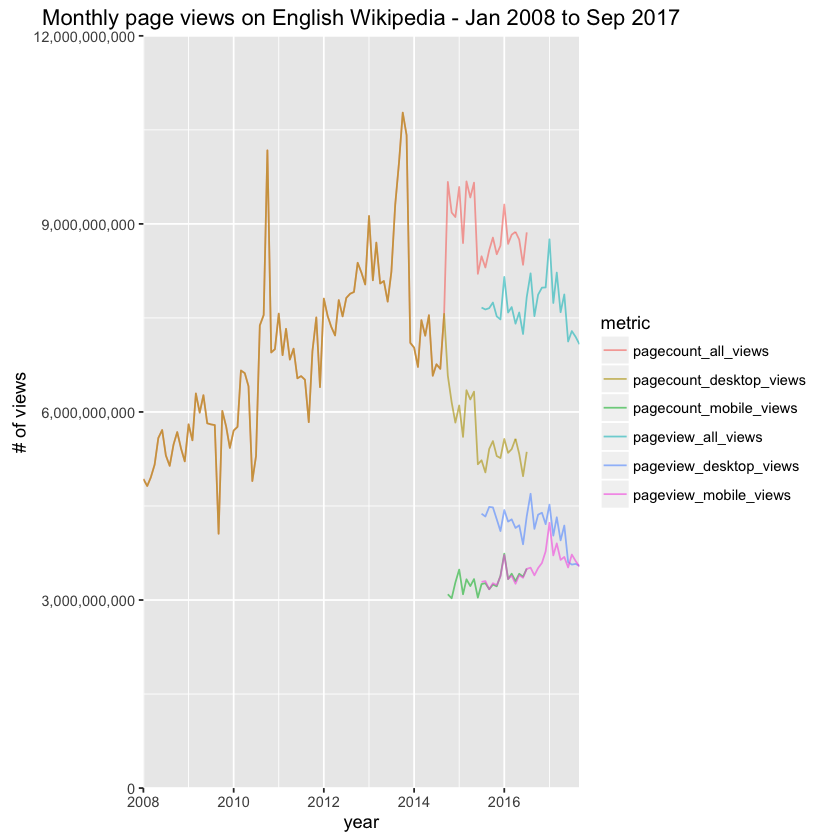

In [46]:
traffic_plot <- ggplot(traffic_tidy, aes(x=date, y=views, color=metric)) + geom_line(alpha=0.6) + scale_y_continuous(name="# of views", labels=scales::comma, expand=c(0, 0), limits=c(0, 12000000000)) + scale_x_datetime(name="year", expand=c(0,0)) + labs(title="Monthly page views on English Wikipedia - Jan 2008 to Sep 2017")
traffic_plot

#### e) Export d) to png file

In [47]:
png(filename="wikipedia_traffic.png")
plot(traffic_plot)
dev.off() 

Warning message:
“Removed 393 rows containing missing values (geom_path).”

pdf 
  2